### Problem Set 3

#### Name: Zunda Xu ( zunda@uchicago.edu)

### Part 1 QR decomposition

#### Problem 1

In [1]:
import numpy as np
from scipy import linalg as la
import cmath

In [3]:
def QR_decomposition(A):
    m,n = A.shape
    Q=np.copy(A)
    R=np.zeros((n,n))
    
    for i in range (n):
        R[i,i]=la.norm(Q[:,i])
        Q[:,i]=Q[:,i]/R[i,i]
        for j in range (i+1,n):
            R[i,j]=np.dot(np.transpose(Q[:,j]),Q[:,i])
            Q[:,j]=Q[:,j]-R[i,j]*Q[:,i]
    
    return Q,R

In [4]:
A=np.random.random((6,4))
Q,R= QR_decomposition(A)
print(A.shape,Q.shape,R.shape)

(6, 4) (6, 4) (4, 4)


In [5]:
Q1,R1=la.qr(A,mode="economic")
print(A.shape,Q1.shape,R1.shape)

(6, 4) (6, 4) (4, 4)


In [7]:
np.allclose(np.triu(R),R)

True

In [8]:
np.allclose(Q.T@Q, np.identity(4))

True

In [9]:
np.allclose(Q@R,A)

True

#### Problem 2

In [12]:
def getDet(A):
    m,n = A.shape
    if m!=n:
        print("A is not a square.")
        return
    
    Q1, R1 = QR_decomposition(A)
    det = 1
    for i in range(n):
        det *= R1[i,i]
    return det

In [13]:
B = np.random.random((5,5))
true_det = la.det(B)
my_det = getDet(B)
print("The difference is: ", true_det - my_det)

The difference is:  -0.00496537822398


#### Problem 3

In [14]:
def solveLinearSystem(A, b):
    if abs(la.det(A))<1e-6:
        print("A is not invertible")
        return
    Q1, R1 = QR_decomposition(A)
    y = np.dot(np.transpose(Q1), b)
    m, n = A.shape
    x = np.empty(n)
    for i in range(n-1, -1, -1):
        x[i] = y[i] / R1[i,i]
        for j in range(n):
            y[j] = y[j] - R1[j,i]*x[i]
        
    return x

In [15]:
A2 = np.random.random((5,5))
#add diagonals to make it invertible
A2 = A2 + 100*np.eye(5)
b2 = np.array([1,3,5,7,9])
print(np.dot(A2, solveLinearSystem(A2, b2)))

[ 1.  3.  5.  7.  9.]


#### Problem 4

In [16]:
def householder(A):
    #A should be a matrix of m*n and has rank n
    sign = lambda x : 1 if x>= 0 else -1
    
    m, n = A.shape
    R = np.copy(A)
    Q = np.eye(m)
    for k in range(n):
        u = np.copy(R[k:, k])
        u[0] = u[0] + sign(u[0])*la.norm(u)
        u = u / la.norm(u)
        R[k:, k:] = R[k:, k:] - 2 * np.outer(u, np.matmul(np.transpose(u), R[k:, k:]))
        Q[k:, :] = Q[k:, :] - 2 * np.outer(u, np.matmul(np.transpose(u), Q[k:, :]))
    return np.transpose(Q), R

In [17]:
A = np.random.random((5,3))
Q, R = la.qr(A)
print(A.shape, Q.shape, R.shape)

(5, 3) (5, 5) (5, 3)


In [18]:
my_Q, my_R = householder(A)
np.allclose(my_Q @ my_R, A)

True

In [19]:
np.allclose(my_Q, Q)

True

In [20]:
np.allclose(my_R, R)

True

#### Problem 5

In [22]:
def hessenberg(A):
    sign = lambda x : 1 if x>= 0 else -1
    
    #A is an invertible n*n matrix
    m, n = A.shape
    H = np.copy(A)
    Q = np.eye(m)
    for k in range(n-2):
        u = np.copy(H[k+1:, k])
        u[0] += sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        
        H[k+1: ,k:] -= 2 * np.outer(u, np.matmul(u, H[k+1:, k:]))
        H[:, k+1:] = H[:, k+1:] - 2 * np.outer(np.dot(H[:, k+1:], u), u.T)
        Q[k+1:, :] -= 2 * np.outer(u, np.matmul(np.transpose(u),Q[k+1:, :]))

    return H, np.transpose(Q)

A5 = np.random.random((8,8))
#add diagonals to make it invertible
A5 += 5*np.eye(8)
H, Q = la.hessenberg(A5, calc_q = True)
my_H, my_Q = hessenberg(A5)

In [23]:
np.allclose(my_H, H)

True

In [24]:
np.allclose(my_Q, Q)

True

### Part 2: Least Squares and Computing Eigenvalues

#### Problem 1 

In [25]:
def lsbyQR(A, b):
    #A is a m*n matrix, b is n*1 vector
    Q, R = la.qr(A, mode = "economic")
    #the linear system then becomes R \hat{x} = Q.T b
    #print(R)
    
    y = np.dot(np.transpose(Q), b)
    m, n = A.shape
    x_hat = np.empty(n)
    for i in range(n-1, -1, -1):
        x_hat[i] = y[i] / R[i,i]
        #update y
        for j in range(n):
            y[j] = y[j] - R[j,i]*x_hat[i]
        
    return x_hat

In [27]:
A = np.array([[-1,1], [0, 1], [1, -1], [-2, 1]])
b = np.array([0 , -1 , -2, 1])
lsbyQR(A, b)

array([-1. , -0.5])

#### Problem 2

In [4]:
import matplotlib.pyplot as plt

In [30]:
def LSLine():
    data = np.load("housing.npy")
    years = data[:, 0]
    prices = data[:, 1]
    
    constants = np.ones(len(years))
    A = np.column_stack((years, constants))
    coeff = lsbyQR(A, prices)
    print("Slope: ", coeff[0], "Intercept: ", coeff[1])
    plt.plot(years, prices, "o", markersize = 4)
    plt.xlabel("Year")
    plt.ylabel("Price Index")
    plt.title("Linear Regression of Price Index with Year")
    plt.plot(np.arange(18), coeff[0]*np.arange(18)+coeff[1])
    plt.show()

Slope:  3.37476604278 Intercept:  164.080962567


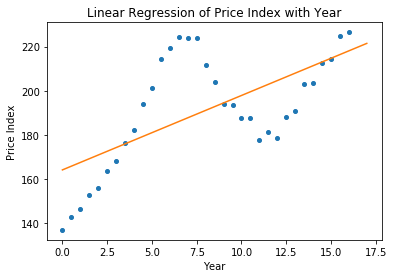

In [31]:
LSLine()

#### Problem 3

Is the calculated result the same from np.polyfit?  True


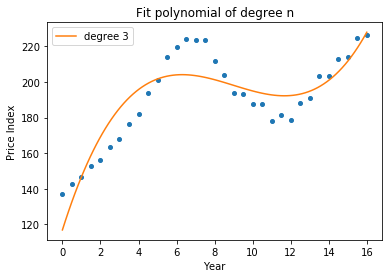

In [37]:
def fit_polynomial(n, x_vec, b_vec):
    # a degree n polynomial should have the form [a_n, a_{n-1}, ..., a_1, a_0].T * [x^n, ,,,, x, 1]
    # create a vandermonde matrix 
    A = np.vander(x_vec, n+1)
    coeff = la.lstsq(A, b_vec)[0]
    
    #regression polynomial
    my_poly = np.poly1d(coeff)
    
    #plot true values
    plt.plot(x_vec, b_vec, "o", markersize = 4)
    plt.xlabel("Year")
    plt.ylabel("Price Index")
    plt.title("Fit polynomial of degree n")
    
    #plot estimated values
    x_start = x_vec.min()
    x_end = x_vec.max()
    my_label = "degree " +str(n)
    plt.plot(np.linspace(x_start, x_end, 100), my_poly(np.linspace(x_start, x_end, 100)), label = my_label)
    plt.legend()
    
    #check with polyfit
    pf_coeff = np.polyfit(x_vec, b_vec, n)
    print("Is the calculated result the same from np.polyfit? ", np.allclose(coeff, pf_coeff))
    
    plt.show()
    

data = np.load("housing.npy")
years = data[:, 0]
prices = data[:, 1]
#degree 3
fit_polynomial(3, years, prices)

Is the calculated result the same from np.polyfit?  True


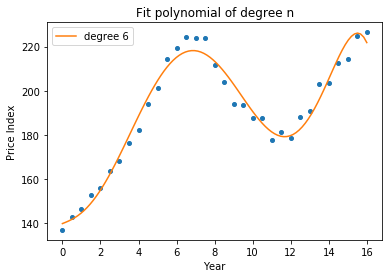

In [38]:
#degree 6
fit_polynomial(6, years, prices)

Is the calculated result the same from np.polyfit?  True


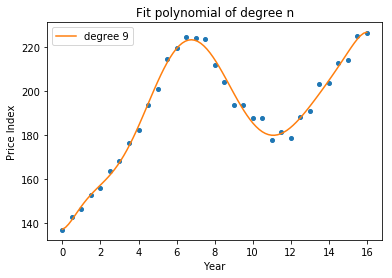

In [39]:
#degree 9
fit_polynomial(9, years, prices)

Is the calculated result the same from np.polyfit?  False


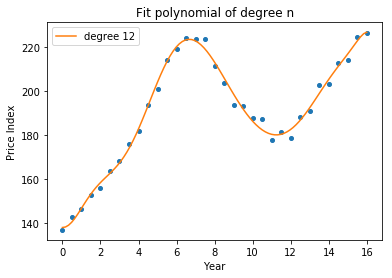

In [40]:
#degree 12
fit_polynomial(12, years, prices)

#### Problem 4

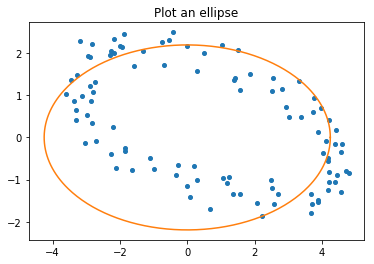

In [42]:
ellipse = np.load("ellipse.npy")
x_vec = ellipse[:, 0]
y_vec = ellipse[:, 1]

def plot_ellipse(x_vec, y_vec):
   #create a linear systems
    x2_vec = x_vec **2
    y2_vec = y_vec **2
    #RHS is a columns of ones
    b_vec = np.ones_like(x_vec)
    A = np.column_stack((x2_vec, y2_vec))
    coeff = la.lstsq(A, b_vec)[0]
    a = np.sqrt(1.0 / coeff[0])
    b = np.sqrt(1.0 / coeff[1])
    
    #plot
    plt.plot(x_vec, y_vec, "o", markersize = 4)
    theta_grid = np.linspace(0, 2*np.pi, 360)
    plt.plot(a*np.cos(theta_grid), b*(np.sin(theta_grid)))
    plt.title("Plot an ellipse")
    plt.show()
plot_ellipse(x_vec, y_vec)

#### Problem 5

In [43]:
def powerMethod(A, maxitr, tol):
    m, n = A.shape
    x_0 = np.random.rand(n) + np.ones(n) # make it larger to avoid rounding error
    x_0 = x_0 / la.norm(x_0)
    currentitr = 0
    diff = 10
    
    while (currentitr<maxitr) or (diff > tol):
        x_prime = np.matmul(A, x_0)
        x_prime = x_prime / la.norm(x_prime)
        diff = la.norm(x_prime - x_0)
        x_0 = x_prime
        currentitr += 1
    eigval = np.dot(x_0, np.matmul(A, x_0))
    eigvec = x_0
    return eigval, eigvec

A = (np.random.random((10,10)) ) # make it larger to avoid rounding error
eigs, vec = la.eig(A)
loc = np.argmax(eigs)
lamb , x = eigs[loc], vec[loc]
my_lamb, my_x = powerMethod(A, 10000, 1e-16)
print("Does the eigvalue converge to true eigvalue?")
print(np.allclose(lamb, my_lamb))
print("Does the corresponding eigenvector satisfy Ax = lambda x?")
print(np.allclose(np.abs(my_lamb * my_x), np.abs(np.dot(A, my_x))))


Does the eigvalue converge to true eigvalue?
True
Does the corresponding eigenvector satisfy Ax = lambda x?
True


#### Problem 6 

In [44]:
def QRfindeig(A, N, tol):
    m, n = A.shape    
    S, temp = la.hessenberg(A, calc_q = True)   
    for k in range(N):
        Q, R = la.qr(S)
        S = np.matmul(R, Q)
    eigs = []
    
    i = 0
    while i < n:
        if (i == (n-1)) or (abs(S[i+1,i])<tol):
            eigs.append(S[i,i])
        else:
            a = S[i,i]
            b = S[i,i+1]
            c = S[i+1, i]
            d = S[i+1, i+1]
            lamba_1 = 0.5 * (a + d + cmath.sqrt((a+d)^2 - 4*(a*d-b*c)))
            lamba_2 = 0.5 * (a + d - cmath.sqrt((a+d)^2 - 4*(a*d-b*c)))
            eigs.append(lambda_1)
            eigs.append(lambda_2)
            i += 1
        i += 1
    return eigs
            
#Construct a random symmetric matrix
A = np.random.random((5,5))
A = A + A.T
my_evals = QRfindeig(A, 1000, 1e-8)
my_evals.sort()
print("Calculation: ", my_evals)
evals, evecs = la.eig(A)
evals.sort()
print("True values: ", evals)

Calculation:  [-0.87834467436491814, -0.11548222622004391, 0.8448893706989864, 0.97890960208205857, 5.0490382957509796]
True values:  [-0.87834467+0.j -0.11548223+0.j  0.84488937+0.j  0.97890960+0.j
  5.04903830+0.j]


From the results shown above, we can find that the two results are almost the same.

### Part 3: SVD and Image Compression

#### Problem 1

In [47]:
def computeSVD(A,tol):
    lamda,V = la.eig(np.dot(A.conj().T,A))
    #get singular values
    sigma = np.sqrt(lamda)
    index = ((-1)*sigma).argsort()
    sigma = sigma[index]
    V = V[:,index]
    
    r = sum(i > tol for i in sigma)
    sigma1 = sigma[:r]
    V1 = V[:,:r]
    U1 = np.dot(A,V1)/sigma1
    return U1, sigma1, V1.conj().T

In [51]:
A = np.random.random((6,4))
U, s_vec, V = computeSVD(A, 1e-8)
print("Results:")
print("U is:")
print(U)
print("Sigma is:")
print(s_vec)
print("V^H is:")
print(V)

Results:
U is:
[[ 0.42178755+0.j -0.66375799+0.j  0.14349853+0.j  0.28942512+0.j]
 [ 0.36535515+0.j  0.57505026+0.j -0.18215559+0.j  0.13683074+0.j]
 [ 0.26752933+0.j  0.01221534+0.j  0.66160116+0.j -0.67177202+0.j]
 [ 0.26926052+0.j -0.24301106+0.j -0.71155129+0.j -0.60164736+0.j]
 [ 0.54549843+0.j -0.11748058+0.j -0.00476815+0.j  0.28928350+0.j]
 [ 0.49695993+0.j  0.39463559+0.j  0.04672724+0.j  0.02383930+0.j]]
Sigma is:
[ 2.16963261+0.j  0.94486510+0.j  0.39194819+0.j  0.34681929+0.j]
V^H is:
[[ 0.56179438  0.26357075  0.69308111  0.36681891]
 [ 0.77465396  0.13891455 -0.46797478 -0.40201193]
 [ 0.06899331  0.14859559 -0.54694474  0.82098156]
 [ 0.28202523 -0.94294886  0.03859575  0.17268346]]


In [52]:
U2, s_vec2, V2 = la.svd(A)
print("True SVD:")
print(U2)
print(s_vec2)
print(V2)

True SVD:
[[-0.42178755 -0.66375799 -0.14349853 -0.28942512 -0.51141599 -0.1249622 ]
 [-0.36535515  0.57505026  0.18215559 -0.13683074 -0.2611509  -0.64477105]
 [-0.26752933  0.01221534 -0.66160116  0.67177202  0.05666234 -0.18993282]
 [-0.26926052 -0.24301106  0.71155129  0.60164736 -0.00545735  0.01139401]
 [-0.54549843 -0.11748058  0.00476815 -0.2892835   0.77632351 -0.0473699 ]
 [-0.49695993  0.39463559 -0.04672724 -0.0238393  -0.25364403  0.72815283]]
[ 2.16963261  0.9448651   0.39194819  0.34681929]
[[-0.56179438 -0.26357075 -0.69308111 -0.36681891]
 [ 0.77465396  0.13891455 -0.46797478 -0.40201193]
 [-0.06899331 -0.14859559  0.54694474 -0.82098156]
 [-0.28202523  0.94294886 -0.03859575 -0.17268346]]


From the results shown above, we find that the results are the same.

#### Problem 2

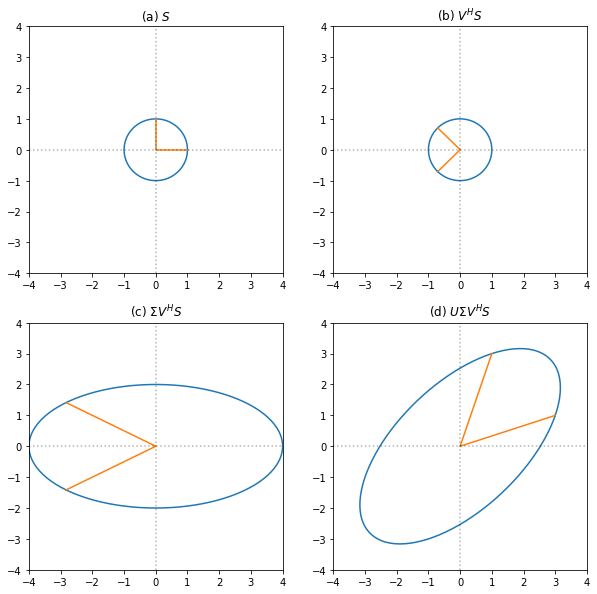

In [54]:
def visualizeSVD(A):
    # A is an 2*2 matrix
    S=np.zeros((2,200))
    theta=np.linspace(0.0, 2*np.pi, 200)
    theta=np.sort(theta)
    S[0]=np.cos(theta)
    S[1]=np.sin(theta)
    E=np.array(([1,0,0],[0,0,1]))
    
    
    
    
    plt.figure(figsize = [10,10])
    
    axis = np.linspace(-4, 4, 10)
    
    U,sigma,Vh = la.svd(A, full_matrices=True)
    Sigma=np.diag(sigma)
    VhS = np.dot(Vh, S)
    VhE = np.dot(Vh, E)
    SigmaVhS = np.dot(Sigma, VhS)
    SigmaVhE = np.dot(Sigma, VhE)
    USigmaVhS = np.dot(U, SigmaVhS)
    USigmaVhE = np.dot(U, SigmaVhE)
        
    #plot 1
    plt.subplot(2,2,1)
    plt.plot(S[0], S[1])
    plt.plot(E[0], E[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(a) " + r"$S$")
        
    #plot 2
    plt.subplot(2,2,2)
    plt.plot(VhS[0], VhS[1])
    plt.plot(VhE[0], VhE[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(b) " + r"$V^H S$")
    
    #plot 3
    plt.subplot(2,2,3)
    plt.plot(SigmaVhS[0], SigmaVhS[1])
    plt.plot(SigmaVhE[0], SigmaVhE[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(c) " + r"$\Sigma V^H S$")
    
    #plot 4
    plt.subplot(2,2,4)
    plt.plot(USigmaVhS[0], USigmaVhS[1])
    plt.plot(USigmaVhE[0], USigmaVhE[1])
    plt.plot(axis, np.zeros_like(axis), "k:", alpha = 0.3)
    plt.plot(np.zeros_like(axis), axis, "k:", alpha = 0.3)
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("(d) " + r"$U \Sigma V^H S$")
    
    plt.show()
       
A = np.array([[3,1], [1,3]])
visualizeSVD(A)

#### Problem 3

In [3]:
def lowRankApprox(A, s):
    U,sigma,Vh = la.svd(A, full_matrices=False)
    if s > np.linalg.matrix_rank(A): 
        raise ValueError('s should be less than rank')
    U = U[:,:s]
    sigma = sigma[:s]
    Vh=Vh[:s,:]
    return U, sigma, Vh, U.size+sigma.size+Vh.size

A=np.random.random((10,10))
lowRankApprox(A,6)

(array([[-0.31900065,  0.42309832, -0.22652013, -0.03928849,  0.50748161,
         -0.21401618],
        [-0.40400724, -0.33263825,  0.3808652 , -0.2355532 ,  0.02787659,
         -0.17944666],
        [-0.2063472 ,  0.44828268,  0.36389632,  0.04475014, -0.61988102,
         -0.065919  ],
        [-0.30440594, -0.26763057,  0.51662131,  0.32047795,  0.11090032,
          0.2584713 ],
        [-0.26575045,  0.05520746, -0.32974754, -0.46768276, -0.46551625,
          0.1508275 ],
        [-0.37574506,  0.22075717, -0.17952681,  0.56740793, -0.09461772,
         -0.35039101],
        [-0.35407505,  0.16480906, -0.11485643, -0.07540641,  0.17937257,
          0.71989553],
        [-0.3243465 ,  0.17937729,  0.1430079 , -0.22501106,  0.2085472 ,
         -0.03919217],
        [-0.32775095, -0.49991638, -0.47795761,  0.30059531, -0.19916457,
          0.06214138],
        [-0.22355417, -0.27698358, -0.03552695, -0.38847117,  0.06436673,
         -0.4262315 ]]),
 array([ 5.11980455,  1.4351

#### Problem 4

In [4]:
def SVDgivenEps(A, eps):
    
    U, sigma, Vh = la.svd(A, full_matrices=False)
    if eps < sigma.min(): 
        raise ValueError('invalid input')
    
    s = getRankNeeded(sigma, eps)
    print("We will use until the ", s+1, "th largest singular value")
    print("The curent singular value is ", sigma[s])
    print("The next singular value is ", sigma[s+1])


    U = U[:,:s+1]
    sigma = sigma[:s+1]
    Vh=Vh[:s+1,:]
    return U, sigma, Vh, U.size+sigma.size+Vh.size
    
    
            
def getRankNeeded(sigma, eps):
    # we assume at least need rank 1 approximation
    for i in range(1, len(sigma)):
        if sigma[i] < eps:
            return i - 1
    raise ValueError("epsilon is too small")
    
    
A = np.random.random((10,10))
U_s, sigma_s, Vh_s, size_s = SVDgivenEps(A, 0.3)
A_s = U_s@np.diag(sigma_s)@Vh_s
print("The approximation error is ", la.norm(A-A_s))
print("Note that the error is less than $\epsilon$")

We will use until the  8 th largest singular value
The curent singular value is  0.427382544476
The next singular value is  0.214500902832
The approximation error is  0.214666933014
Note that the error is less than $\epsilon$


#### Problem 5

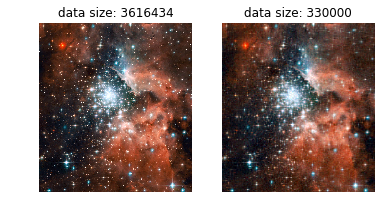

In [8]:
def getResultAndDataSize(matrix, s):
    #print(np.linalg.matrix_rank(matrix))
    U_s, sigma_s, Vh_s, size_s = lowRankApprox(matrix, s)
    return U_s@np.diag(sigma_s)@Vh_s, size_s
    
def imageCompression(imageFile, s):
    imageMatrix = plt.imread(imageFile)/255
    
    #get original data size
    original_shape = imageMatrix.shape
    originalDataSize = 1
    for i in range(len(original_shape)):
        originalDataSize *= original_shape[i]
    
    if imageMatrix.ndim==3:
        #this is a color image
        R=imageMatrix[:,:,0]
        G=imageMatrix[:,:,1]
        B=imageMatrix[:,:,2]
        R_s, size_R = getResultAndDataSize(R, s)
        G_s, size_G = getResultAndDataSize(G, s)
        B_s, size_B = getResultAndDataSize(B, s)
        compressed = image=np.dstack((R_s,G_s,B_s))
        compressed = np.clip(compressed,0,1)
        newDataSize = size_R + size_G + size_B
        #display original image and new image
        plt.subplot(1,2,1)
        plt.imshow(imageMatrix)
        plt.axis("off")
        string = "data size: " + str(originalDataSize)
        plt.title(string)
        
        plt.subplot(1,2,2)
        plt.imshow(compressed)
        plt.axis("off")
        string = "data size: " + str(newDataSize)
        plt.title(string)
        plt.show()
        
    else:
        #this is a gray image
        compressed, newDataSize = getResultAndDataSize(imageMatrix, s)
        plt.subplot(2,1,1)
        plt.imshow(imageMatrix, cmap = "gray")
        plt.axis("off")
        
        plt.subplot(2,1,2)
        plt.imshow(compressed)
        plt.axis("off")
        plt.show()
        
imageCompression("hubble.jpg", 50)

### Part 4: SVD and Image Compression

#### Problem 1

In [9]:
from numpy.linalg import matrix_power

In [10]:
def f(A,k,A_D):
    if np.allclose(np.dot(A,A_D),np.dot(A_D, A))==True:
        if np.allclose(np.dot(matrix_power(A,k+1),A_D), matrix_power(A,k))==True:
            if np.allclose(np.dot(A_D,A,A_D),A_D)==True:
                return True
            else:return False
        else: return False
    else: return False

In [11]:
A=np.array(([1,3,0,0],[0,1,3,0],[0,0,1,3],[0,0,0,0]))
A.reshape(4,4)
A_D=np.array(([1,-3,9,81],[0,1,-3,-18],[0,0,1,3],[0,0,0,0]))
A_D.reshape(4,4)
f(A,1,A_D)

True

In [12]:
B=np.array(([1,1,3],[5,2,6],[-2,-1,-3]))
B.reshape(3,3)
B_D=np.array(([0,0,0],[0,0,0],[0,0,0]))
B_D.reshape(3,3)
f(B,3,B_D)

True

#### Problem 2

In [13]:
from numpy.linalg import inv

In [17]:
def problem_2(A,tol):
    n=len(A)
    f = lambda x: abs(x) > tol
    Q1,S,k1 = la.schur(A, sort=f)
    f = lambda x: abs(x) <= tol
    Q2,T,k2 = la.schur(A, sort=f)
    U=np.concatenate((S[:,:k1], T[:,:n-k1]), axis=1)
    U_1=inv(U)
    V=U_1@A@U
    Z=np.zeros((n,n))
    if k1!=0:
        M_1=inv(V[:k1,:k1])
        Z[:k1,:k1]=M_1
    return U@Z@U_1  

In [18]:
problem_2(A,0.01)

array([[  1.,  -3.,   9.,  81.],
       [  0.,   1.,  -3., -18.],
       [  0.,   0.,   1.,   3.],
       [  0.,   0.,   0.,   0.]])

In [19]:
f(A,1,problem_2(A,0.01))

True

#### Problem 3

In [20]:
def problem_3(A):
    n =len(A)
    degree = np.sum(A, axis = 0)
    D = np.diag(degree)
    L = D - A
    I = np.identity(n)
    R = np.zeros((n,n))
    for j in range(n):
        L1 = L.copy()
        L1[:, j] = I[:, j]
        L1_D = p2(L1, .0000001)
        R[:, j] = L1_D.diagonal()
        R[j, j] = 0
    return R

In [21]:
A=np.array([[0, 1, 0, 0], [1,  0,  1,  0], [0,  1,  0,  1], [0,  0,  1,  0]])
problem_3(A)

array([[ 0.,  1.,  2.,  3.],
       [ 1.,  0.,  1.,  2.],
       [ 2.,  1.,  0.,  1.],
       [ 3.,  2.,  1.,  0.]])

#### Problem 4 and 5

In [24]:
import pandas as pd

In [27]:
class LinkPredictor:
    def __init__(self, name):
        data= pd.read_csv(name, header=None)
        self.list = np.unique(np.concatenate((data[0], data[1])))
        n = len(self.list)
        adj = np.zeros((n, n))
        for i in data.index:
            friend1, friend2 = data[0][i], data[1][i]
            friend1loc = np.where(friend1 == self.list)
            friend2loc = np.where(friend2 == self.list)
            adj[friend1loc, friend2loc] = 1
            adj[friend2loc, friend1loc] = 1
        self.adjacency_matrix = adj
        self.resistance_matrix = problem_3(self.adjacency_matrix)
    def predict_link(self,node):
        #zero out all entries that represent connected nodes
        new_matrix=self.resistance_matrix*(1-self.adjacency_matrix)
        if node=='None':
            minval = np.min(new_matrix[np.nonzero(new_matrix)])
            loc= np.where(new_matrix==minval)
            return self.list[loc[0]], self.list[loc[1]]
        elif not node in self.list:
            raise ValueError("invalid input")
        else :
            loc = np.where(self.list == node)
            col = new_matrix[:,loc]
            minval = np.min(col[col > 0])
            location = np.where(col==minval)
            return self.list[location[0]]
    def add_link(self,node1,node2):
        if (not node1 in self.list) or (not node2 in self.list):
            raise ValueError("invalid inputs")
        else:
            loc1 = np.where(self.list==node1)
            loc2 = np.where(self.list==node2)
            self.adjacency_matrix[loc1, loc2] = 1
            self.adjacency_matrix[loc2, loc1] = 1

In [28]:
a=LinkPredictor("social_network.csv")
a.predict_link('Melanie')

array(['Carol'], dtype=object)

In [29]:
a.predict_link('Alan')

array(['Sonia'], dtype=object)

In [30]:
a.predict_link('None')

(array(['Oliver'], dtype=object), array(['Emily'], dtype=object))

In [31]:
a.add_link('Emily','Alan')

### Part 5: Page Rank

#### Problem 1

In [32]:
from scipy.sparse import dok_matrix

In [33]:
def webpage_p1(filename):
    nodes=[]
    with open(filename, 'r') as myfile:
        for line in myfile:
            try:
                line = list(map(int, line.strip().split()))
                nodes.append(line)
            except:
                pass
    N = np.amax(nodes) + 1
    A = np.zeros((N,N))
    for i in range (0,N):
        for j in range (0,N):
            if [i,j] in nodes:
                A[i,j]=1
    return A

In [34]:
webpage_p1('matrix.txt')

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

#### Problem 2

In [36]:
def webpage_p2(A):
    m,n = A.shape
    A[A.sum(axis=1) == 0, :] = np.ones(n)
    D=A.sum(axis=1)
    K = A.T / D
    return(K)

In [37]:
webpage_p2(webpage_p1('matrix.txt'))

array([[ 0.        ,  1.        ,  0.125     ,  0.33333333,  0.33333333,
         0.5       ,  1.        ,  1.        ],
       [ 0.        ,  0.        ,  0.125     ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.125     ,  0.33333333,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.125     ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.125     ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.125     ,  0.        ,  0.33333333,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.125     ,  0.33333333,  0.33333333,
         0.5       ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.125     ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

#### Problem 3

In [38]:
def webpage_p3(A,N=None,d=0.85,tol=1e-5):
    if N!=None:
        A=A[:N,:N]
    n=len(A)
    p_0 = np.random.rand(n)
    p_0= p_0/ np.sum(p_0)
    pdist = 100
    count=0
    while (pdist > tol) & (count < 1000):
        p_t = d * A @ p_0 + ((1 - d)/ n)
        pdist = la.norm(p_t - p_0)
        p_0 = p_t
        count += 1
    return(p_0)

In [39]:
webpage_p3(webpage_p2(webpage_p1('matrix.txt')))

array([ 0.43869006,  0.02171029,  0.02786154,  0.02171029,  0.02171029,
        0.02786154,  0.04585394,  0.39460206])

#### Problem 4

In [42]:
def webpage_p4(A,N=None,d=0.85):
    n = len(A)
    K = webpage_p2(A)
    E = np.ones((n, n))
    B = (d * K + ((1 - d) / n) * E)
    eigval, eigvec = la.eig(B)
    p_t = eigvec[:, 0]/ np.sum(eigvec[:,0])
    return p_t

In [43]:
webpage_p4(webpage_p2(webpage_p1('matrix.txt')))

array([ 0.03870928,  0.02641669,  0.48031139,  0.32401996,  0.04643401,
        0.03127529,  0.02641669,  0.02641669])

#### Problem 5

In [44]:
with open('ncaa2013.csv','r') as ncaafile:
    ncaafile.readline()
    winner=[]
    loser=[]
    for line in ncaafile:
        teams=line.strip().split(',')
        winner.append(teams[0])
        loser.append(teams[1])
names = np.unique(np.concatenate((winner, loser)))
n=len(names)
adj=np.zeros((n,n))
for i in range (0,len(winner)):
    name1, name2 = winner[i], loser[i]
    name1loc = np.where(name1 == names)
    name2loc = np.where(name2 == names)
    adj[name2loc, name1loc] = 1
A=webpage_p2(adj)
B=webpage_p3(A,d=0.7)
rank= np.argsort(B)
name_list= names[rank]
print(name_list[-5:][::-1])       

['Duke' 'Butler' 'Louisville' 'Illinois' 'Indiana']


### Part 5: Conditioning and Stability

#### Problem 1

In [49]:
import sympy as sy

In [45]:
def CS_p1(A):
    sigma = la.svd(A)[1]
    a = sigma[0] / sigma[-1]
    return a

In [46]:
A = np.random.rand(6, 6)
np.allclose(CS_p1(A), np.linalg.cond(A))

True

#### Problem 2

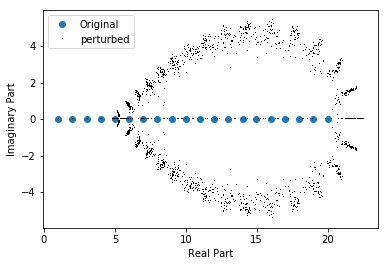

 absolute condition number is 4.00444574615952e-9
 relative condition number is 2763779457.88781


In [50]:
x, i = sy.symbols('x i')
w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
w_coeffs = np.array(w.all_coeffs())
roots = np.roots(np.poly1d(w_coeffs))
plt.plot(roots, np.zeros(20), 'o', label = "Original")
list1 = []
list2 = []
for i in range (0,100):
    c = np.random.normal(1, 1e-10, 21)
    newcoeffs = w_coeffs * c
    newroots = np.roots(np.poly1d(newcoeffs))
    if i == 99:
        plt.plot(newroots.real, newroots.imag, 'k,', label = "perturbed") 
        plt.xlabel("Real Part")
        plt.ylabel("Imaginary Part")
        plt.legend()
    else:
        plt.plot(newroots.real, newroots.imag, 'k,') 
    h = newcoeffs - w_coeffs
    acn = la.norm(newroots - roots, np.inf) / la.norm(h, np.inf)
    rcn = acn * la.norm(w_coeffs, np.inf) / la.norm(roots, np.inf) 
    list1 = list1 + [acn]
    list2 = list2 + [rcn]
plt.show()
print(" absolute condition number is", np.mean(list1))
print(" relative condition number is", np.mean(list2))

#### Problem 3

In [51]:
def CS_p3(A):
    real = np.random.normal(0, 1e-10, len(A))
    imag = np.random.normal(0, 1e-10, len(A))
    H = real + 1j*imag
    A_val = la.eigvals(A)
    eig_val = la.eigvals(A+H)
    diff = A_val - eig_val
    acn = (la.norm(diff, 2)) / (la.norm(H, 2))
    rcn = acn * (la.norm(A, 2)) / (la.norm(diff, 2))
    return acn, rcn

In [52]:
A = np.random.rand(5, 5)
CS_p3(A)

(2.2249042799103753, 8989412212.8667107)

#### Problem 4

In [55]:
def CS_p4(bounds, res=200):  
    x_min, x_max, y_min, y_max = bounds
    x = np.linspace(x_min, x_max, res)
    y = np.linspace(y_min, y_max, res)
    condition = np.zeros((res, res))
    for i in range(res):
        for j in range(res):
            A = np.array([[1, x[i]], [y[j], 1]])
            condition[i,j] = CS_p3(A)[1]
    plt.pcolormesh(x, y, condition, cmap='gray_r')
    plt.show()
   

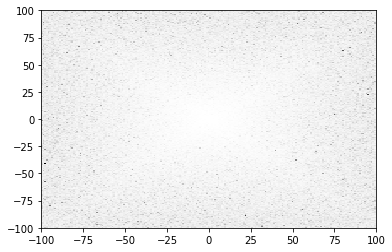

In [56]:
CS_p4([-100,100,-100,100],200)

#### Problem 5

In [5]:
def CS_p5(n):
    xk, yk = np.load('stability_data.npy').T
    A = np.vander(xk, n + 1)
    ck_1 = la.inv(A.T @ A) @ A.T @ yk
    error_1 = np.linalg.norm(A @ ck_1 - yk)
    Q , R = la.qr(A, mode='economic')
    ck_2 = la.solve_triangular(R, Q.T @ yk)
    err_2 = np.linalg.norm(A @ ck_2 - yk)
    plt.plot(xk, yk)
    plt.plot(xk, np.polyval(ck_1, xk), label="Normal Equations")
    plt.plot(xk, np.polyval(ck_2, xk), label = "QR Solver")
    plt.legend()
    plt.show()

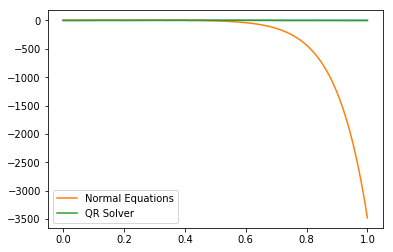

In [6]:
CS_p5(14)

#### Problem 6

In [66]:
from math import sqrt
import math
def CS_p6():
    grid = np.arange(5,51,5)
    x = sy.Symbol('x')
    err=[]
    for n in grid:
        true = float(sy.integrate(x**n * sy.exp(x - 1), (x, 0, 1)))
        estimate = float((-1)**n * sy.subfactorial(n) + (-1)**(n + 1) * sy.factorial(n) / math.e)
        err.append(abs(estimate - true) / abs(true)) 
    plt.plot(grid, np.log(np.array(err)))
    plt.show()

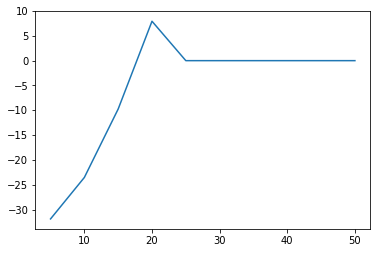

In [67]:
CS_p6()